# Constants

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # only relevant to my own environment

I assume that you have downloaded MIDI dataset and uncompssed into `./midi_dataset/groove/` folder  
https://magenta.tensorflow.org/datasets/groove

In [2]:
DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom low',
   'Tom mid', 
   'Tom high',
   'Clap',
   'Rim' 
]
MIDI_DRUM_MAP = {
   36: 0,
   35: 0,
   38: 1,
   27: 1,
   28: 1,
   31: 1,
   32: 1,
   33: 1,
   34: 1,
   37: 1,
   39: 1,
   40: 1,
   56: 1,
   65: 1,
   66: 1,
   75: 1,
   85: 1,
   42: 2,
   44: 2,
   54: 2,
   68: 2,
   69: 2,
   70: 2,
   71: 2,
   73: 2,
   78: 2,
   80: 2,
   46: 3,
   67: 3,
   72: 3,
   74: 3,
   79: 3,
   81: 3,
   45: 4,
   29: 4,
   41: 4,
   61: 4,
   64: 4,
   84: 4,
   48: 5,
   47: 5,
   60: 5,
   63: 5,
   77: 5,
   86: 5,
   87: 5,
   50: 6,
   30: 6,
   43: 6,
   62: 6,
   76: 6,
   83: 6,
   49: 7,
   55: 7,
   57: 7,
   58: 7,
   51: 8,
   52: 8,
   53: 8,
   59: 8,
   82: 8
}


DRUM_MIDI_MAP = [ # pianoroll to MIDI - reverse
    36, # 0 Kick
    38, # 1 Snare
    42, # 2 Hihat Closed
    46, # 3 Hihat Open
    45, # 4 Tom Low
    47, # 5 Tom Mid
    50, # 6 Tom High
    49, # 7 Clap
    51  # 8 Rim
]

resolution  = 4 # separate quater into 4  = 16 notes per bar

nb_bars = 2 

len_seq = resolution * 4 * nb_bars # length of drumloops in training data - 2 bars
    
nb_notes = len(DRUM_CLASSES) # number of possible MIDI notes  - max_drum_note - min_drum_note


# Training

In [3]:
import numpy as np

matrices_drums = np.load("./tmp/matrices_drum_gm_electronic.npz")['drum_data']
matrices_genres = np.load("./tmp/matrices_drum_gm_electronic.npz")['genre_ids']
GENRES_ALL = np.load("./tmp/matrices_drum_gm_electronic.npz")['genres']

print(GENRES_ALL)
print(matrices_genres.shape)

# Filter genres 
GENRES_USED = [u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
GENRES_ID_USED = [i for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
GENRES = [genre for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]

print(GENRES_ID_USED)
print(GENRES)

NB_GENRES = len(GENRES)
print("%d genres we have" % NB_GENRES)

_drums = []
_genres = []

for genre_id, drum in zip(matrices_genres, matrices_drums):
    if genre_id in GENRES_ID_USED:
        _drums.append(drum)
        genre_id = GENRES_ID_USED.index(genre_id)
        _genres.append(genre_id)

matrices_drums = np.array(_drums)
print(matrices_drums.shape)
matrices_genres = np.array(_genres)
print(matrices_genres.shape)

['Old Skool' 'Trance' 'DnB' 'Basic' 'Downtempo' 'Jungle' 'House'
 'Breakbeat' 'Garage' 'Techno']
(49003,)
[0, 2, 5, 6, 7, 8, 9]
['Old Skool', 'DnB', 'Jungle', 'House', 'Breakbeat', 'Garage', 'Techno']
7 genres we have
(37950, 32, 9)
(37950,)


In [4]:
loss_weights = [1., 1/np.sqrt(NB_GENRES)]
print(loss_weights)

[1.0, 0.3779644730092272]


## Discriminator

In [5]:
import numpy as np
from keras.layers import Input, Dense, Embedding, Flatten, Dropout, Reshape, LSTM, Bidirectional, Lambda, Concatenate, Softmax
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adam
import keras.backend as K
from keras.models import Model, Sequential
from keras import regularizers


droprate = 0.1

# input
drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')

x0 = Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(drum_input) 
x0 = BatchNormalization()(x0)
x0 = Bidirectional(LSTM(128, return_sequences=False, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(x0)
x0 = BatchNormalization()(x0)

x0 = Dropout(droprate)(x0)
x0 = Dense(512, activation='sigmoid')(x0)
genre_output = Dense(NB_GENRES, activation='softmax', name='style_output',
               kernel_regularizer=regularizers.l2(0.01), 
               activity_regularizer=regularizers.l1(0.01))(x0)


# # Conditioning label:
# # Integer 0-NB_GENRES denoting the genre G should generate
# label_input = Input(shape=(1,), dtype='int32')

# # Embedding layer:
# # Turns labels into dense vectors of size z_dim
# # Produces 3D tensor with shape: (batch_size, 1, 28*28*1)
# label_embedding = Embedding(NB_GENRES, np.prod((len_seq, nb_notes)), input_length=1)(label_input)

# # Flatten the embedding 3D tensor into 2D tensor with shape:(batch_size, 28*28*1)
# label_embedding = Flatten()(label_embedding)

# # Reshape label embeddings to have same dimensions as input images
# label_embedding = Reshape((len_seq, nb_notes))(label_embedding)

# # Concatenate images with corresponding label embeddings
# concatenated = Concatenate(axis=-1)([drum_input, label_embedding])

x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(drum_input) 
x = Bidirectional(LSTM(64, return_sequences=False, activation='tanh'))(x)
# x = Bidirectional(LSTM(16, return_sequences=True, activation='tanh'))(x)
# x = Reshape((1024,))(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.01)(x)
gan_output = Dense(1, activation='sigmoid', name='gan_output')(x)

discriminator_c = Model(drum_input, [gan_output,genre_output])
discriminator_c.summary()

optimizer = Adam(lr=0.00001) 
discriminator_c.compile(optimizer=optimizer, loss={'gan_output':'binary_crossentropy','style_output':'categorical_crossentropy'},
                      loss_weights=loss_weights,
                    metrics={'gan_output':'binary_accuracy', 'style_output':'categorical_accuracy'})

Using TensorFlow backend.
/home/nao/anaconda3/envs/p37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nao/anaconda3/envs/p37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nao/anaconda3/envs/p37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nao/anaconda3/envs/p37/lib/pytho

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
drum_input (InputLayer)         (None, 32, 9)        0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 32, 256)      141312      drum_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 256)      1024        bidirectional_1[0][0]            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 32, 128)      37888       drum_input[0][0]                 
____________________________________________________________________________________________

In [6]:
# # temporary model 
# discriminator_a = Model(drum_input, gan_output)
# discriminator_a.summary()

# optimizer = Adam() # higher leraning rate for D
# discriminator_a.compile(optimizer=optimizer, 
#                         loss={'gan_output':'binary_crossentropy'},
#                     metrics={'gan_output':'binary_accuracy'})

In [7]:
# from keras.models import load_model

# classifier = load_model("./tmp/onset_classification_gm_14-0.69.hdf5")
# classifier.summary()


In [8]:
# j = 0

# for i, layer in enumerate(classifier.layers):
#     print (i, layer)
    
# for i, layer in enumerate(discriminator_c.layers):
#     print (i, layer)
    
#     if i <= 4 or layer not in discriminator_a.layers:    
#         w = classifier.layers[j].get_weights()
#         layer.set_weights(w)
# #        layer.trainable = False # freezes the layer
#         j += 1

In [9]:
print (discriminator_c.metrics_names)

['loss', 'gan_output_loss', 'style_output_loss', 'gan_output_binary_accuracy', 'style_output_categorical_accuracy']


## GENERATOR 

In [10]:
from keras.layers import Reshape, Conv2DTranspose, RepeatVector, Activation,Bidirectional,Embedding,multiply
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D

len_input = 100

z_input = Input(shape=(len_input,))  # tensorflow order

# # Conditioning label
# label_input = Input(shape=(1,), dtype='int32')
# label_embedding = Embedding(NB_GENRES, len_input, input_length=1)(label_input)
# label_embedding = Flatten()(label_embedding)

# # Element-wise product of the vectors z and the label embeddings
# inputs2 = multiply([z_input, label_embedding])

# 
x = Dense(512)(z_input)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = Dense(1024)(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = Reshape((32, 32))(x)
x = Dropout(droprate)(x)

x = LSTM(128, return_sequences=True, activation='tanh')(x) 
x = LSTM(128, return_sequences=True, activation='tanh')(x)
note_out = LSTM(9, return_sequences=True, activation='sigmoid')(x)

generator = Model(z_input, note_out)
generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               51712     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096

In [11]:
from keras.models import load_model

generator_tmp = load_model("./models/c_generator-epoch-024-0.92261.h5")
generator_tmp.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       700         input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 100)          0           embedding_2[0][0]                
____________________________________________________________________________________________

/home/nao/anaconda3/envs/p37/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
# j = 0

# for i, layer in enumerate(generator_tmp.layers):
#     print (i, layer)

# for i, layer in enumerate(generator.layers):
#     print(i, layer)
    
# for i, layer in enumerate(discriminator_c.layers):
#     print (i, layer)
    
#     if i <= 4 or layer not in discriminator_a.layers:    
#         w = classifier.layers[j].get_weights()
#         layer.set_weights(w)
# #        layer.trainable = False # freezes the layer
#         j += 1

## ADVERSARIAL MODEL 

In [13]:
def style_ambiguity_loss(y_true, y_pred):
    even_dist = K.ones_like(y_pred) * 1.0/float(len(GENRES))
    return K.categorical_crossentropy(even_dist, y_pred, from_logits=False)

In [14]:

# define input for the combined GAN model
z_input = Input(shape=(len_input,))  # tensorflow order
# label_input = Input(shape=(1,), dtype='int32')
img_gan = generator(z_input)

# training is disable for discriminator in adversarial model
discriminator_c.trainable = False 

# define output
prediction_gan = discriminator_c(img_gan)
print(prediction_gan)

# define combined GAN model
gan = Model(z_input, prediction_gan)
optimizer = Adam(lr=0.0001)
gan.compile(optimizer=optimizer, loss=['binary_crossentropy', style_ambiguity_loss], 
            loss_weights=loss_weights, metrics=['binary_accuracy'])
gan.summary()


[<tf.Tensor 'model_1/gan_output/Sigmoid:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'model_1/style_output/Softmax:0' shape=(?, 7) dtype=float32>]
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 32, 9)             802152    
_________________________________________________________________
model_1 (Model)              [(None, 1), (None, 7)]    842760    
Total params: 1,644,912
Trainable params: 799,080
Non-trainable params: 845,832
_________________________________________________________________


In [15]:
gan.metrics_names

['loss',
 'model_1_loss',
 'model_1_loss',
 'model_1_binary_accuracy',
 'model_1_binary_accuracy_1']

## Training

In [16]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import random
import pretty_midi
from IPython.display import Audio
from scipy.io import wavfile

# Create Z for generator
def get_noise(batch_size, len_input):
#    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, len_input])
    
    # better to use a spherical Z. according to https://github.com/soumith/ganhacks
    noise = np.random.normal(0.0, 0.50, size=[batch_size, len_input])
    return noise

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()  
        
        import pretty_midi

def play_drum_matrix(mat, tempo=120.0):
    # generate audio
    audio_data = get_audio_from_drum_matrix(mat, tempo=tempo)
    display(Audio(audio_data, rate=44100))
    return audio_data

def get_audio_from_drum_matrix(mat, tempo=120.):
    pm = pretty_midi.PrettyMIDI(initial_tempo=tempo) # midi object
    pm_inst = pretty_midi.Instrument(0, is_drum=True) # midi instrument
    
    timestep = (60./tempo) / 4. # duration of a 16th note
    for position, timeslot in enumerate(mat):
        for inst, onset in enumerate(timeslot):
            if onset > 0.:
                note_number = DRUM_MIDI_MAP[inst]
                velocity = int(onset * 127.)
                start = timestep * position
                end = timestep * (position + 0.5)
                
                # create a midi note
                note = pretty_midi.Note(velocity=velocity, pitch=note_number, start=start, end=end)
                pm_inst.notes.append(note)
    pm.instruments.append(pm_inst)

    # midi -> audio
    audio_data = pm.fluidsynth()
    return audio_data






In [17]:
from tensorboard_logger import configure, log_value

from datetime import datetime
now = datetime.now()
logdir_prefix = "/tmp/tf_logs_can/"
logdir = logdir_prefix + now.strftime("%Y%m%d-%H%M%S") 
cmd = "tensorboard --logdir=" + logdir_prefix
print (cmd)

configure(logdir, flush_secs=5)

tensorboard --logdir=/tmp/tf_logs_can/


epoch 110 0
d_loss 0.45214903354644775 d_cat_acc 0.9583333333333334 a_loss 1.2219157 a_cat_loss 2.00336
d_accuracy 0.7708333333333334


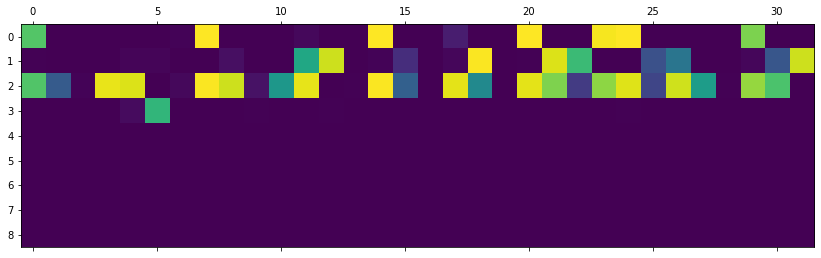

epoch 110 100
d_loss 0.44557373722394306 d_cat_acc 0.9895833333333334 a_loss 1.284687 a_cat_loss 2.0000496
d_accuracy 0.828125


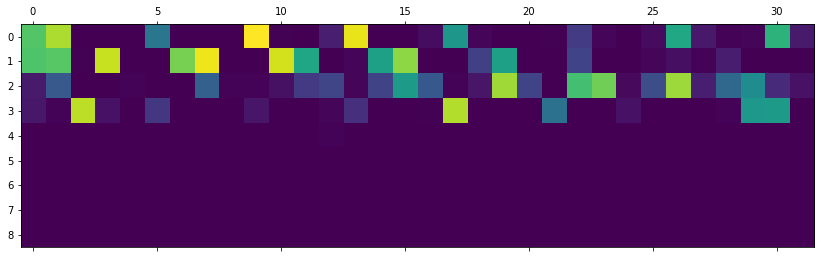

epoch 110 200
d_loss 0.45284003019332886 d_cat_acc 0.953125 a_loss 1.3620143 a_cat_loss 1.9995385
d_accuracy 0.8151041666666666


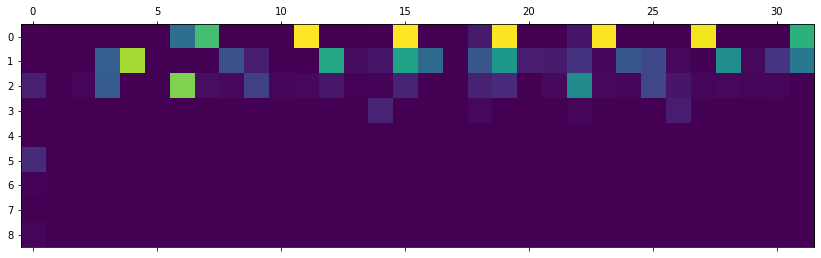

epoch 110 300
d_loss 0.5048174858093262 d_cat_acc 0.9895833333333334 a_loss 1.4659499 a_cat_loss 1.9989326
d_accuracy 0.7552083333333334


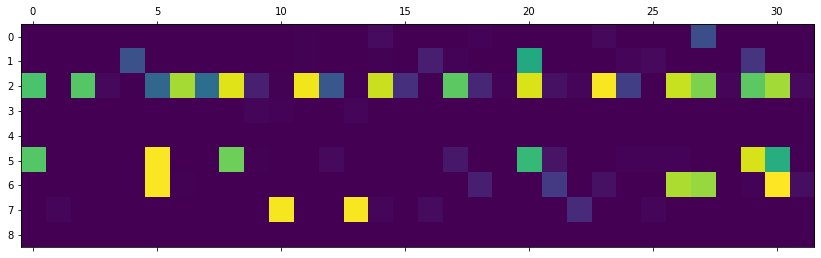

epoch 110 400
d_loss 0.448693851629893 d_cat_acc 0.9791666666666666 a_loss 1.1806481 a_cat_loss 1.996732
d_accuracy 0.7916666666666666


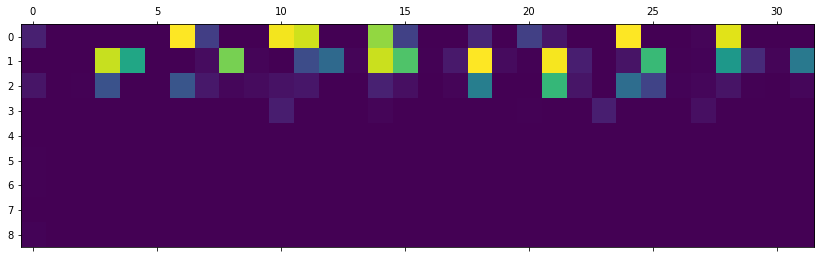

epoch 110 500
d_loss 0.4830275575319926 d_cat_acc 0.984375 a_loss 1.1582088 a_cat_loss 2.0143995
d_accuracy 0.7604166666666666


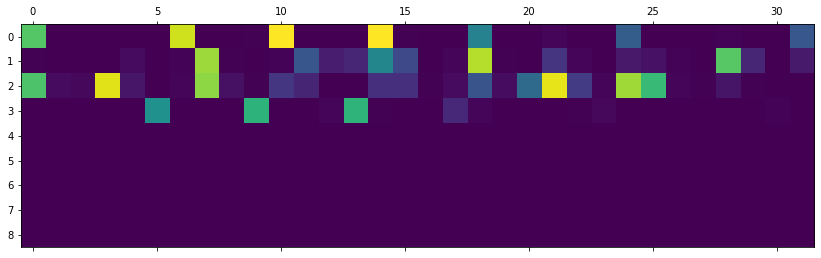

epoch 111 0
d_loss 0.5405807495117188 d_cat_acc 0.9895833333333334 a_loss 1.345852 a_cat_loss 2.0231137
d_accuracy 0.7526041666666666


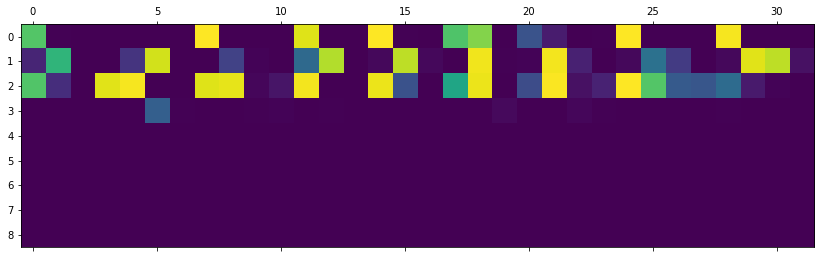

epoch 111 100
d_loss 0.4274623493353526 d_cat_acc 0.984375 a_loss 1.4195273 a_cat_loss 2.002191
d_accuracy 0.8177083333333334


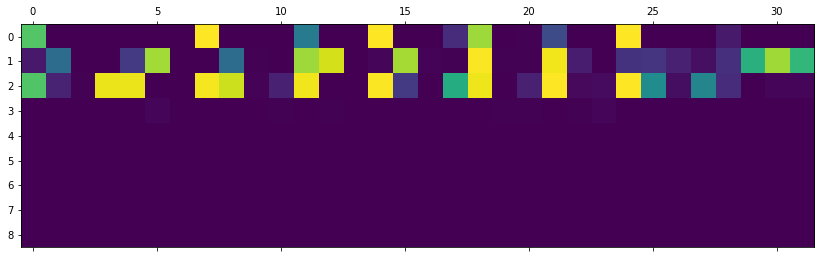

epoch 111 200
d_loss 0.4315178394317627 d_cat_acc 0.9791666666666666 a_loss 1.2592876 a_cat_loss 1.9906634
d_accuracy 0.8229166666666666


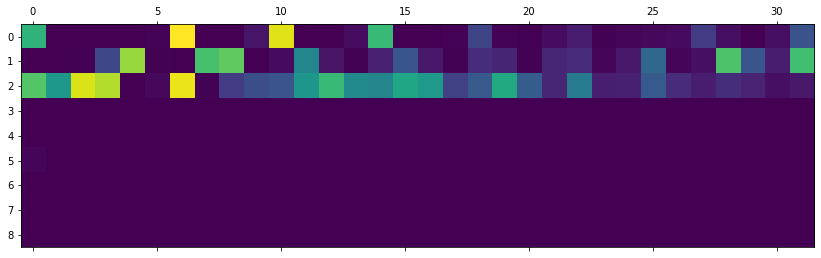

In [ ]:
from keras.utils import to_categorical 

batch_size = 64
nb_epochs = 500
nb_samples = matrices_drums.shape[0]

K_unrolled = 3
MAX_LOSS_RATIO = 5.0

# Labels for real drums: all ones
real_labels = np.ones((batch_size, 1)) # * 0.9 #you can try one-sided soft labeling for better stability

# Labels for fake drums: all zeros
fake_labels = np.zeros((batch_size, 1))

train_d = True
train_g = True

for epoch in range(0, nb_epochs):
    nb_steps = int(nb_samples/batch_size)
    
    for repeat in range(nb_steps):
        step = nb_steps * epoch + repeat
        
        if train_d:
            
            m_d_loss = 0.0
            m_d_accuracy = 0.0
            m_d_accuracy_fake = 0.0
            m_d_accuracy_real = 0.0
            m_d_loss_cat = 0.0
            m_d_cat_accuracy = 0.0
            
            for j in range(K_unrolled):
                # training data
                random_indices = np.random.randint(0, matrices_drums.shape[0], size=batch_size)
                drum_train = matrices_drums[random_indices, :, :]
                labels_traing = matrices_genres[random_indices]
                labels_traing_categorical = to_categorical(labels_traing, num_classes=NB_GENRES)

                # generated samples
                noise = get_noise(batch_size, len_input)
                drum_fake = generator.predict(noise)

                # training D
                _, d_loss_real, d_loss_cat, d_acc_real, cat_accuracy = discriminator_c.train_on_batch(drum_train,
                                                                    [real_labels, labels_traing_categorical]) 
                _, d_loss_fake, _, d_acc_fake, _ = discriminator_c.train_on_batch(drum_fake,
                                                                [fake_labels, labels_traing_categorical]) 
                #print(d_acc_real, d_acc_fake, cat_accuracy)
                
                m_d_loss += 0.5 * (d_loss_real + d_loss_fake)
                m_d_loss_cat += d_loss_cat
                m_d_accuracy +=  0.5 * (d_acc_real + d_acc_fake)
                m_d_accuracy_fake += d_acc_fake
                m_d_accuracy_real += d_acc_real
                m_d_cat_accuracy += cat_accuracy
                # cache for later update
    #             cache_weights = discriminator.get_weights()
            
            m_d_loss /= float(K_unrolled)
            m_d_accuracy /= float(K_unrolled)
            m_d_accuracy_fake /= float(K_unrolled)
            m_d_accuracy_real /= float(K_unrolled)
            m_d_loss_cat /= float(K_unrolled)
            m_d_cat_accuracy /= float(K_unrolled)
           
            # store value
            log_value("D loss", m_d_loss, step)  
            log_value("D accuracy", m_d_accuracy, step)  
            log_value("D accuracy - fake", m_d_accuracy_fake, step) 
            log_value("D accuracy - real", m_d_accuracy_real, step) 
            
            log_value("D category loss", m_d_loss_cat, step)  
            log_value("D category accuracy", m_d_cat_accuracy, step) 
            log_value("D total loss", m_d_loss + m_d_loss_cat, step)
            
        # training G
        if train_g:
            y = np.ones([batch_size, 1]) # watch out the label! it should be one here        

            noise = get_noise(batch_size, len_input)

            # Get a batch of random labels
            labels_random = np.random.randint(0, NB_GENRES, batch_size).reshape(-1, 1)
            labels_random_categorical = to_categorical(labels_random, num_classes=NB_GENRES)
                
            _, m_a_loss, m_a_cat_loss, m_a_accuracy, _ = gan.train_on_batch(noise, [y, labels_random_categorical])
            
            # store value
            log_value("G loss", m_a_loss, step)
            log_value("G accuracy", m_a_accuracy, step)
            log_value("style amguity loss", m_a_cat_loss, step)
            log_value("G total loss", m_a_loss + m_a_cat_loss, step)
        
        if train_d and train_g:
            if m_a_loss / m_d_loss > MAX_LOSS_RATIO:
                train_d = False
                train_g = True
                print("Pausing D")
            elif m_d_loss / m_a_loss > MAX_LOSS_RATIO:
                train_g = False
                train_d = True
                print("Pausing G")
        else:
            train_d = True
            train_g = True
            
        # update layer 
#         discriminator.set_weights(cache_weights)
 
        if repeat % 100 == 0:
            
            print("epoch", epoch, repeat)
            print("d_loss", m_d_loss, "d_cat_acc", m_d_cat_accuracy,
                "a_loss", m_a_loss, 'a_cat_loss', m_a_cat_loss) # print mean loss)
            print("d_accuracy", m_d_accuracy )
            
            # sample output
            noise = get_noise(1, len_input)
            labels_random = np.random.randint(0, NB_GENRES, 1).reshape(-1, 1)
            drum_generated = generator.predict([noise])           
            plot_drum_matrix(drum_generated)
            
            # sample audio output
            audio_data = play_drum_matrix(np.squeeze(drum_generated))
            #wavfile.write("audio/drum_%05d_%05d.wav" % (epoch, repeat), 44100, audio_data)
            
            print
            print
            
                        
    # store temporary models
    if (epoch + 1) % 5 == 0:
        generator.save("./tmp/can2_generator-epoch-%03d-%0.5f.h5" % (epoch, m_a_loss))
        #gan.save("./tmp/can2_pretrain_gan-epoch-%03d-%0.5f.h5" % (epoch, m_a_loss))
        #discriminator_c.save("./tmp/can2_pretrain_discriminator_c-epoch-%03d-%0.5f.h5" % (epoch, m_d_loss))
        clear_output(wait=True)

In [ ]:
generator.save("./tmp/can_generator.h5")
gan.save("./tmp/can_gan.h5")
discriminator.save("./tmp/can_discriminator.h5")

In [ ]:
for i in range(3):
    noise = get_noise(1, len_input)
    drum_generated = generator.predict(noise)
    plot_drum_matrix(drum_generated)

# MIDI Playback

In [ ]:
# midi playback
def note_matrix_to_sequence(mat, threshold = 0.5):
    seq = []
    for row in mat[:]:
        arow = [[i, r] for i, r in enumerate(row) if r > threshold]
        seq.append(arow)
    return seq

import OSC
max_poly = 6 # maximum number of instruments played at the same time

client = OSC.OSCClient()
client.connect( ('10.0.1.14', 2014) ) 

def send_sequence_via_osc(seq):
    ## the most basic ##
    msg = OSC.OSCMessage()
    msg.setAddress("/seq")
    msg.append(max_poly * 2)
    
    for notes in seq:
        for i in range(max_poly):
            if len(notes) > i:
                msg.append([notes[i][0]+min_drum_note, notes[i][1]])
            else:
                msg.append([0, 0])
    client.send(msg)
    
def playback_seq_via_osc(mat):
    send_sequence_via_osc(note_matrix_to_sequence(mat, 0.2))

In [ ]:
import time

repeat = 1

for j in range(100):
    noise1 = get_noise(1, len_input) 
    noise2 = get_noise(1, len_input) 
    
    for i in range(repeat):
        noise = noise1 * (1.0 - i/float(repeat)) + noise2 * i/float(repeat)
        drum_generated = generator.predict(noise)
        mat = np.squeeze(drum_generated)
        playback_seq_via_osc(mat)
        time.sleep(4.0)
        clear_output(wait=True)